# Users behavior clustering

install retentioneering if running from google.colab or for the first time:

In [1]:
!pip3 install retentioneering

## Basic example

We will use a sample user activity dataset to illustrate how behavior clustering works. Let’s first import retentioneering, import sample dataset and update config to set used column names:

In [3]:
import retentioneering

# load sample data
data = retentioneering.datasets.load_simple_shop()

# setup column names:
retentioneering.config.update({
    'user_col': 'user_id',
    'event_col':'event',
    'event_time_col':'timestamp',
})

## Trajectories vectorization

Each user trajectory is represented as a sequence of events. Before we apply any ML algorithms to users dataset we need a way to convert each user trajectory from a sequence of events to a numerical vector. This field of ML learning extensively was developed in applications for text processing. Text analysis in some sense is similar to analysis of discrete user trajectories of behavioural logs. In text processing each text document (in our case - user trajectory) consists of discrete words (in our case - event names) and we need to convert text to numerical values. Let’s work through some examples.

Function rete.extract_features() returns a dataframe of vectorized user trajectories:

In [4]:
vec = data.rete.extract_features(feature_type='count',
                                 ngram_range=(1, 1))

vec

,cart,catalog,delivery_choice,delivery_courier,delivery_pickup,lost,main,payment_card,payment_cash,payment_choice,payment_done,product1,product2
122915,1,18,0,0,0,1,7,0,0,0,0,4,2
463458,0,8,0,0,0,1,1,0,0,0,0,0,1
1475907,1,5,1,1,0,1,2,0,0,1,0,1,2
1576626,0,0,0,0,0,1,1,0,0,0,0,0,0
2112338,0,3,0,0,0,1,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999275109,1,2,1,0,1,1,0,0,0,0,0,0,0
999642905,1,2,1,1,0,0,1,0,0,1,1,0,0
999914554,1,10,0,0,0,1,5,0,0,0,0,1,0
999916163,2,2,0,0,0,1,0,0,0,0,0,0,0


In the obtained dataframe each row corresponds to a vector representing each user from the original dataset. Each column (or vector dimension) corresponds to unique events in the dataset and the values are how many times a particular event was present in this user’s trajectory. These are supported types of vectorization (parameter feature_type):
- ‘count’ : number of occurrences of given event
- ‘binary’ : 1 if user had given event at least once and 0 otherwise
- ‘frequency’ : same as count but normalized to total number of events in user trajectory
- ‘tfidf’ : term frequency–inverse document frequency, frequency of event in user trajectory but weighted to overall frequency of event in the dataset.  


Second important parameter for extract_features is ngram_range, which sets the lower and upper limit for event sequences to be extracted. For example an ngram_range of (1, 1) means only individual events, (1, 2) means unigrams and bigrams of events, and (2, 2) means only bigrams of events. 

## Clusterization

After we know general idea about user trajectories vectorization we can now use get_clusters method to split users on groups based on how similar is their behavior:

In [5]:
data.rete.get_clusters(method='kmeans',
                       n_clusters=8,
                       refit_cluster=True,
                       feature_type='tfidf',
                       ngram_range=(1,2));

Under the hood each user trajectory (sequence of event names) got transformed to a numeric vector. In the example above we used ‘ftidf’ vectorization (default vectorizer), where vocabulary is sequences of events from 1 to 2 (parameter ngram_range), meaning that we count individual events up to sequences of 2 (bi-grams).

Parameter n_clusters corresponds to the number of desired clusters. Parameter method - type of clusterization algorithm to use (currently support ‘kmeans’ and ‘gmm’).

Result of the method above is assigned to a new rete attribute: cluster_mapping, which is a dictionary containing user_id’s for each cluster:

In [1]:
#data.rete.cluster_mapping

Now, if we need to obtain all user_id’s from a specific cluster, it can be done very easily using cluster_mapping dictionary. For example:

In [7]:
clus_2 = data.rete.cluster_mapping[2]

here, clus_2 will contain all user_id’s of users from cluster 2.

## Visualizing results

Very often it is useful to have a high-level overview of the results of clusterization immediately after clusterization was done. Clusters statistics can be shown with the clusterization by including plot_type parameter:

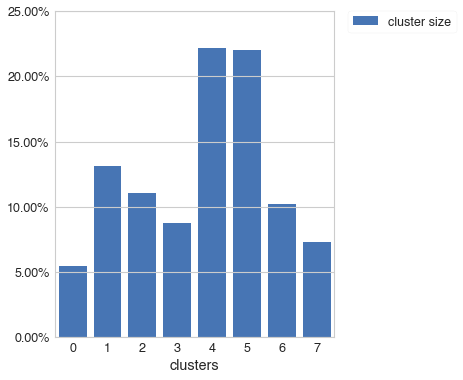

In [8]:
data.rete.get_clusters(method='kmeans',
                       feature_type='tfidf',
                       n_clusters=8,
                       ngram_range=(1,2),
                       plot_type='cluster_bar');

By default it shows the relative size of each cluster. We can add conversion to any specified event to the clusters statistics using parameter targets, where we can specify target events. High-level overview bar plot will now include conversion rate (% of users within the cluster who have specified event at least once) for specified target:

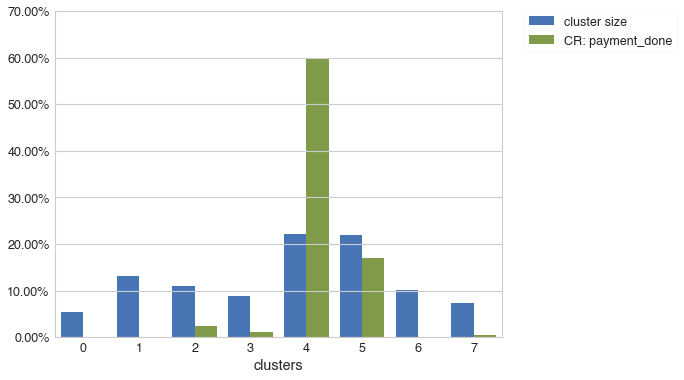

In [9]:
data.rete.get_clusters(method='kmeans',
                       feature_type='tfidf',
                       n_clusters=8,
                       ngram_range=(1,2),
                       plot_type='cluster_bar',
                       targets=['payment_done']);

Parameter targets can contain any number of events. For each added event, corresponding conversion rate will be included to cluster overview bar plot. This is very useful when you need to get a quick intuition about the resulting clusters:

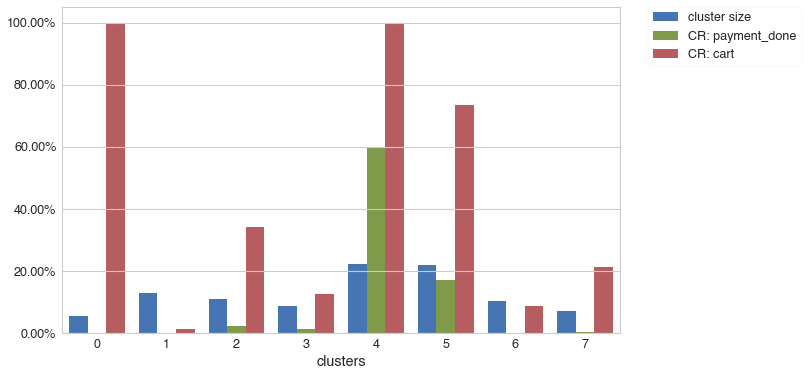

In [10]:
data.rete.get_clusters(method='kmeans',
                       feature_type='tfidf',
                       n_clusters=8,
                       ngram_range=(1,2),
                       plot_type='cluster_bar',
                       targets=['payment_done','cart']);

In example above we can see that clusters 4 and 5 have relatively high conversion rates to purchase compared to other clusters (CR: ‘payment_done’). Interestingly, cluster 0 has very high conversion to visit ‘cart’ (same as clusters 4 and 5) but don’t have any conversions to ‘payment_done’. This must be a cluster of users who reach the cart but get lost somewhere between cart and payment_done. This way we can immediately start building our intuition about resulting clusters.

## Exploring individual clusters

After clusterization is done we can explore individual clusters using a full arsenal of retentioneering tools. Function filter_cluster can be used to isolate individual dataset for a given cluster number or list of clusters:

In [11]:
clus_0 = data.rete.filter_cluster(0)

Now, clus_0 is a regular pandas dataframe containing only users from cluster 0. Since it is regular pandas dataframe we can directly apply rete tools such as plot_graph or step_matrix to explore it:

In [12]:
clus_0.rete.plot_graph(thresh=0.1,
                       weight_col='user_id',
                       targets = {'lost':'red',
                                  'payment_done':'green'})

'experiments/graph_2020-10-05 14_35_28_724074.html'

We can see that this cluster #0 consists of users who explore catalog, products 1 and 2, then reach the ‘cart’, but lost after the cart. To see how users in cluster 0 get to the cart we can plot step_matrix centered around cart:

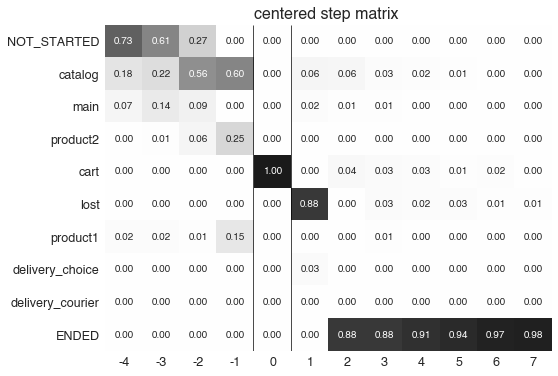

In [13]:
clus_0.rete.step_matrix(max_steps=12,
                        centered={'event': 'cart',
                                  'left_gap': 4,
                                  'occurrence': 1});

Other clusters can be explored in a similar way. Note, that dataframe containing multiple clusters can be extracted by passing a list of cluster numbers to filter_cluster() function. For example, if we would like to obtain dataset only containing users from clusters 4 and 5 for subsequent analysis, we can simply do:

In [14]:
clus_0_7 = data.rete.filter_cluster([0,7])

## Compare clusters

Function rete.cluster_event_dist() helps to quickly understand at a high level behavior pattern within a given cluster by comparing the distribution of top_n events within selected cluster vs all dataset or with another cluster. Let’s see an example. Suppose we would like to explore cluster 2, which has a low conversion rate to ‘payment_done’ event.

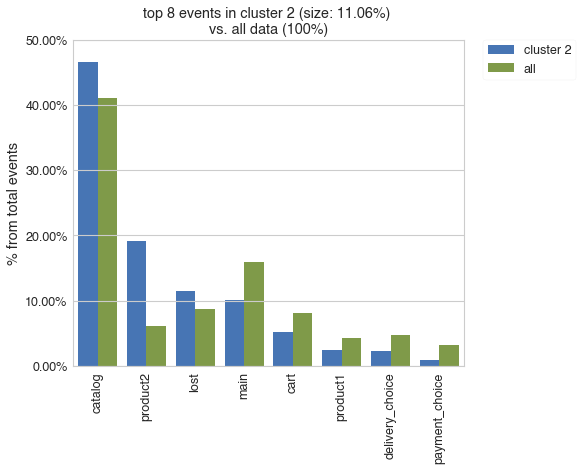

In [15]:
data.rete.cluster_event_dist(2)

We can immediately see the distribution of events (by default top_n = 8) within selected cluster 2 compared with the distribution from the whole dataset. Percents on Y axis correspond to how frequently a given event is present in the given cluster. On the histogram above we can see that users from cluster 2 are much more often interacting with product 2 compared with the entire dataset.

We can also compare two clusters between each other. For this we need to pass two positional arguments corresponding to cluster numbers.

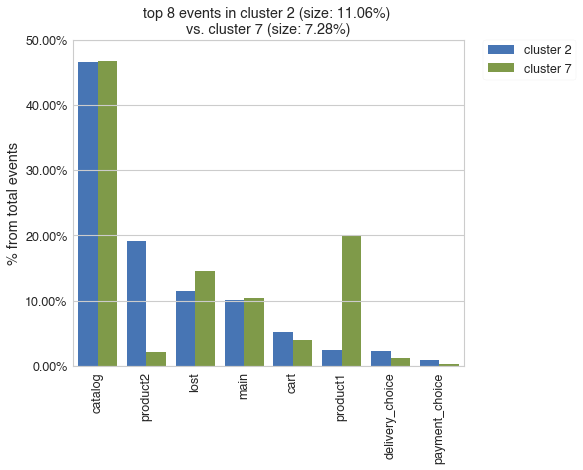

In [16]:
data.rete.cluster_event_dist(2, 7)

Here we can see a comparison of top 8 frequent events in cluster 2 vs cluster 7. We can see that cluster 7 is similar to cluster 2. Both clusters have low conversion rate, but users from cluster 7 more frequently interact with product 1 whereas users from cluster 2 interact with product 2.

Note, that in the above example Y-axis values were showing the percentage that a given event represented from the selected cluster. Very often we are actually more interested to compare percentages of users who have particular events between two groups. This type of normalization can be used by passing the name of the index column we would like to normalize by. In our case it’s user_id’s: weight_col=’user_id’ (default None):

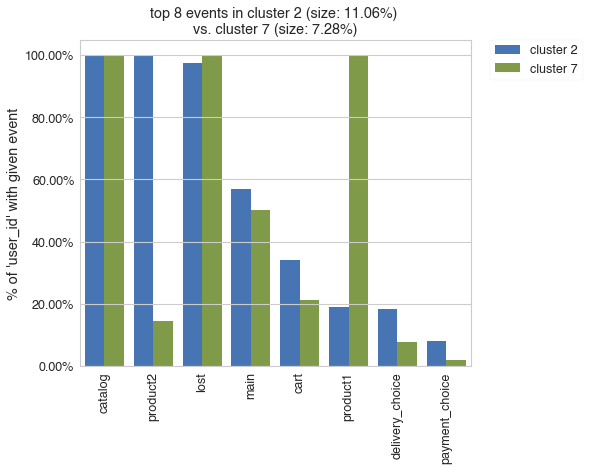

In [17]:
data.rete.cluster_event_dist(2, 7,
                            weight_col='user_id')

Now in the histogram above we can see that actually 100% of users from cluster 2 have interacted with product 2 and 100% of users from cluster 7 have interacted with product 1. It gives. All users from both clusters have interacted with catalog and were lost (no conversion). Interestingly, non-converted users who interacted with product 2 (from cluster 2) are more likely to visit cart (35% of users) before they are lost, than lost users who interacted with product 1 (20% of users from cluster 7). This effect was difficult to notice when we compared cluster 2 and 7 without weight_col=’user_id’ normalization.

If there are some events of particular importance which you always want to include in comparison (regardless of selected top_n parameter) you can pass those events as a list as targets parameter. Those events will always appear in comparison histogram on the right after the dashed line (in the same order as specified):

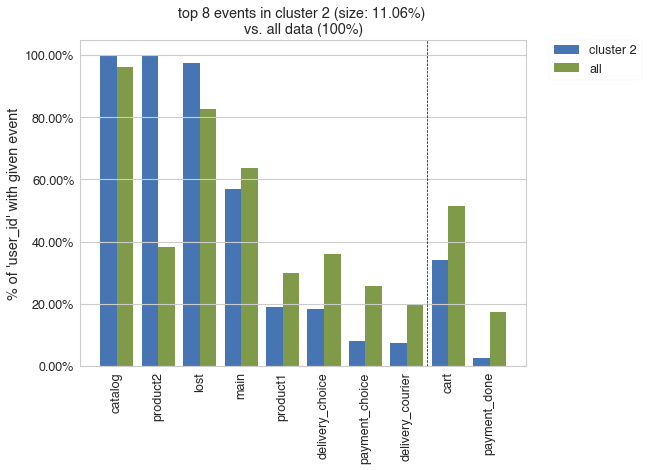

In [18]:
data.rete.cluster_event_dist(2,
                            weight_col='user_id',
                            targets=['cart','payment_done'])

## Visualize cluster using project()

Sometimes it is useful to have a high-level overview of your users trajectories. This can be done by dimension reduction techniques where multidimensional vectorized user trajectories are transformed to two dimensional vectors. After such transformation we can visualize all users on a single plane where each user will be represented with a single dot. This dimension-reduction transformation is done in a way that approximately conserves the distances from high-dimension meaning that users with similar behavior will end up as close dots on a plane. Retentioneering library provides tools for two popular transformation methods: [tsne](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) and [umap](https://umap-learn.readthedocs.io/en/latest/index.html). Let's see an example: 

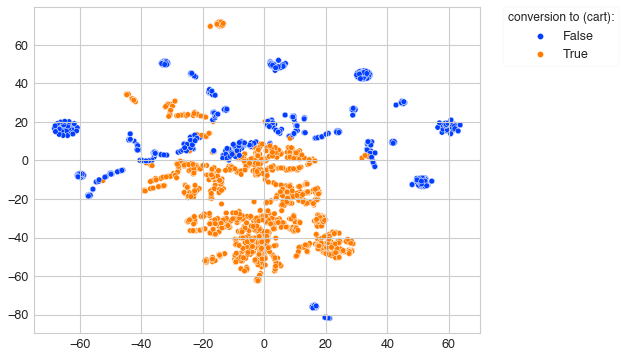

In [26]:
data.rete.project(plot_type ='targets',
                  targets = ['cart'],
                  method='tsne');

Here each dot on the plane above represents each user. 

As keyword arguments to project() function you can pass any parameters supported by scikit-learn [tsne](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) implementation. For example:

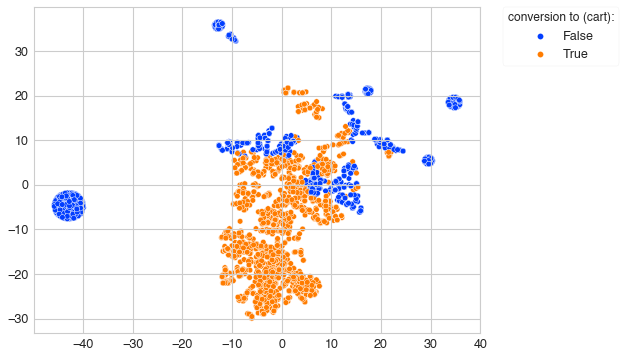

In [27]:
data.rete.project(plot_type ='targets',
                  targets = ['cart'],
                  method='tsne',
                  perplexity = 128);

Parameter targets (list of event names) used to highlight users who reach any target event vs those who have not. For example, we can highlight users on the projection map who reach the product page (product1 or product2):

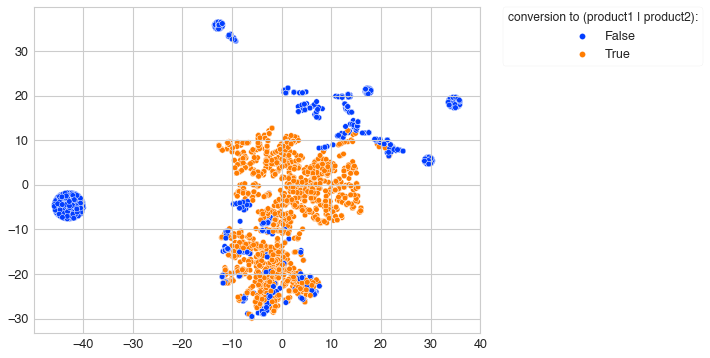

In [28]:
data.rete.project(plot_type ='targets',
                  targets = ['product1', 'product2'],
                  method='tsne',
                  perplexity = 128);

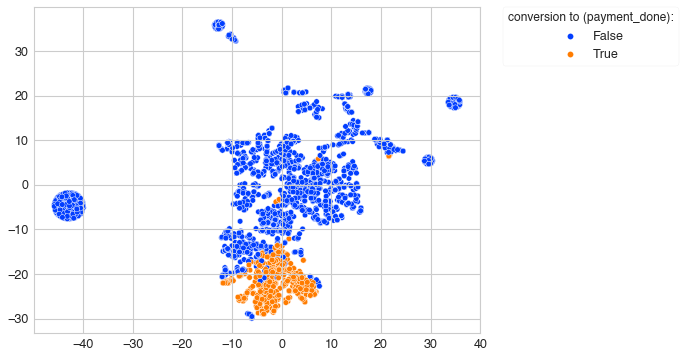

In [29]:
data.rete.project(plot_type ='targets',
                  targets = ['payment_done'],
                  method='tsne',
                  perplexity = 128);

Another option for plot_type is visualization of clustering results. After you run clustering as in this notebook above, you can pass plot_type ='clusters':

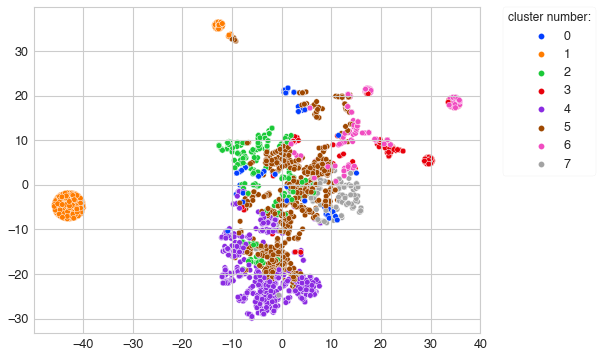

In [30]:
data.rete.project(plot_type ='clusters',
                  method='tsne',
                  perplexity=128);

You can see from this high-level map, for example, that cluster 4 contains most of the highly engaged users, whereas cluster 1 represents users with very distinct low-engagement behavior.
